### Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [4]:
# Loss Function
def loss_function(output, target):
    return torch.mean((output - target) ** 2)

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img, img_tensor


image_path = r'..Images\frame_00238.jpg'
original_img, input_tensor = load_image(image_path)
plt.imshow(original_img)
plt.title("Original Input Image")
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\PAWANESH\\DEFT-DPT\\Model Training\\Images\\frame_00238.jpg'

### Define DEFT Module with all corrections

In [107]:
# DEFT Module
class LocalizationNetwork(nn.Module):
    def __init__(self, input_channels):
        super(LocalizationNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 10, kernel_size=5)
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 6)  # 6 affine parameters
        self.fc2.weight.data.normal_(mean=0.0, std=0.001)
        self.fc2.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float) + 0.0001 * torch.randn(6))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        flattened_size = x.view(x.shape[0], -1).shape[1]
        if not hasattr(self, 'computed_fc1') or (self.fc1.in_features != flattened_size):
            self.fc1 = nn.Linear(flattened_size, 32).to(x.device)
            nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
            nn.init.constant_(self.fc1.bias, 0.0)
            self.computed_fc1 = True

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        theta = self.fc2(x)
        theta = theta.view(-1, 2, 3)
        return theta


class WeightingModule(nn.Module):
    def __init__(self, sigma=8.0):
        super(WeightingModule, self).__init__()
        self.lambda_param = nn.Parameter(torch.tensor(0.7))
        self.sigma = sigma

    def forward(self, grid):
        dist2 = grid[..., 0]**2 + grid[..., 1]**2
        weight = 1 + self.lambda_param * torch.exp(-dist2 / (2 * self.sigma ** 2))
        return weight.unsqueeze(-1)


class DEFTModule(nn.Module):
    def __init__(self, input_channels, sigma=0.5):
        super(DEFTModule, self).__init__()
        self.localization = LocalizationNetwork(input_channels)
        self.weighting = WeightingModule(sigma)

    def forward(self, x):
        theta = self.localization(x)
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        weight = self.weighting(grid)  # (N, H, W, 1)
        x_transformed = F.grid_sample(x, grid, align_corners=False)
        weight = weight.permute(0, 3, 1, 2)
        weight = weight.expand(-1, x.shape[1], -1, -1)

        x_weighted = x_transformed * weight
        return x_weighted, x_transformed, weight

### Instantiate DEFT Model

In [108]:
device = input_tensor.device
deft = DEFTModule(input_channels=3).to(device)
deft.eval()
with torch.no_grad():
    _ = deft(input_tensor)
target_tensor = input_tensor.clone()
optimizer = optim.Adam(deft.parameters(), lr=0.0001)
num_epochs = 100
lambda_optimizer = optim.Adam([deft.weighting.lambda_param], lr=0.0001)

deft.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()  
    lambda_optimizer.zero_grad()  
    x_weighted, x_transformed, weight = deft(input_tensor)
    loss = loss_function(x_transformed, target_tensor)
    lambda_reg = 0.001 * (deft.weighting.lambda_param ** 2).mean()
    loss += lambda_reg
    loss.backward()
    optimizer.step()
    lambda_optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Lambda: {deft.weighting.lambda_param.item():.4f}")

Epoch [10/100], Loss: 0.000589, Lambda: 0.6980
Epoch [20/100], Loss: 0.000518, Lambda: 0.6960
Epoch [30/100], Loss: 0.000491, Lambda: 0.6940
Epoch [40/100], Loss: 0.000482, Lambda: 0.6920
Epoch [50/100], Loss: 0.000478, Lambda: 0.6900
Epoch [60/100], Loss: 0.000474, Lambda: 0.6880
Epoch [70/100], Loss: 0.000471, Lambda: 0.6860
Epoch [80/100], Loss: 0.000468, Lambda: 0.6841
Epoch [90/100], Loss: 0.000466, Lambda: 0.6821
Epoch [100/100], Loss: 0.000463, Lambda: 0.6801


### Evaluation and Visualization

Updated Affine Parameters:
[[[ 1.0000004e+00  1.4897687e-06 -1.5557598e-06]
  [ 2.4430938e-06  1.0000006e+00  2.2317035e-06]]]
Lambda Parameter after Training: 0.6801


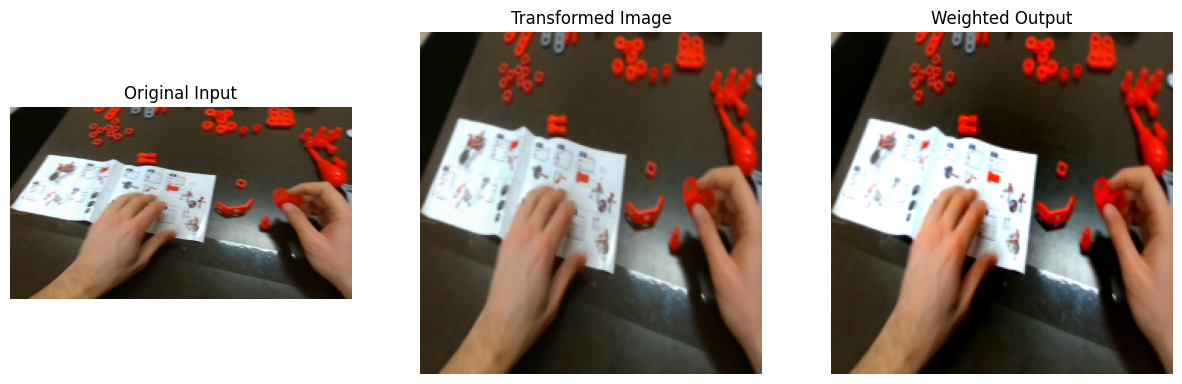

Bounding box in original image pixels: (x1, y1, x2, y2) = (308, 173, 1611, 906)


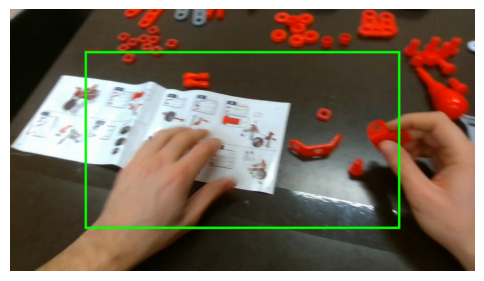

In [109]:
deft.eval()
with torch.no_grad():
    x_weighted, x_transformed, weight = deft(input_tensor)
with torch.no_grad():
    theta = deft.localization(input_tensor)
print(f"Updated Affine Parameters:\n{theta.detach().cpu().numpy()}")
print(f"Lambda Parameter after Training: {deft.weighting.lambda_param.item():.4f}")
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(original_img)
ax[0].set_title("Original Input")
ax[0].axis('off')
transformed_img = x_transformed[0].permute(1, 2, 0).detach().cpu().numpy()
transformed_img = transformed_img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
transformed_img = np.clip(transformed_img, 0, 1)
ax[1].imshow(transformed_img)
ax[1].set_title("Transformed Image")
ax[1].axis('off')


weighted_img = x_weighted[0].permute(1, 2, 0).detach().cpu().numpy()
weighted_img = weighted_img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
weighted_img = np.clip(weighted_img, 0, 1)
ax[2].imshow(weighted_img)
ax[2].set_title("Weighted Output")
ax[2].axis('off')

plt.show()


weight_np = weight.detach().cpu().numpy()[0] 

if weight_np.ndim == 3:
    weight_map = weight_np.mean(axis=0) 
else:
    weight_map = weight_np
H, W = weight_map.shape

thresh = 0.5 * (weight_map.max() - weight_map.min()) + weight_map.min()
mask = weight_map > thresh
coords = np.where(mask)

if coords[0].size == 0:
    box_w, box_h = int(W * 0.2), int(H * 0.2)
    cx, cy = W // 2, H // 2
    x1, y1 = max(0, cx - box_w//2), max(0, cy - box_h//2)
    x2, y2 = min(W-1, cx + box_w//2), min(H-1, cy + box_h//2)
else:
    y1, x1 = coords[0].min(), coords[1].min()
    y2, x2 = coords[0].max(), coords[1].max()
    # pad a bit
    pad_x = max(1, int(0.05 * W))
    pad_y = max(1, int(0.05 * H))
    x1 = max(0, x1 - pad_x)
    y1 = max(0, y1 - pad_y)
    x2 = min(W - 1, x2 + pad_x)
    y2 = min(H - 1, y2 + pad_y)


orig_w, orig_h = original_img.size 
scale_x = orig_w / W
scale_y = orig_h / H

orig_x1 = int(x1 * scale_x)
orig_y1 = int(y1 * scale_y)
orig_x2 = int((x2 + 1) * scale_x)
orig_y2 = int((y2 + 1) * scale_y)

print(f"Bounding box in original image pixels: (x1, y1, x2, y2) = ({orig_x1}, {orig_y1}, {orig_x2}, {orig_y2})")

boxed_img = original_img.copy()
draw = ImageDraw.Draw(boxed_img)
draw.rectangle([orig_x1, orig_y1, orig_x2, orig_y2], outline=(0, 255, 0, 180), width=10)
# optionally put lambda value
draw.text((orig_x1, max(orig_y1-12, 0)), f"lambda={deft.weighting.lambda_param.item():.3f}", fill='red')

plt.figure(figsize=(6,6))
plt.imshow(boxed_img)
plt.title("")
plt.axis('off')
plt.show()
